<b>Importing Libraries

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import models, datasets,transforms
from torchvision.utils import make_grid
from sklearn.metrics import f1_score   
import os
import zipfile
from torchsummary import summary
import shutil


<b>Retrieve Tiny Imagenet data directly from Stanford data source

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
  
# Unzip raw zip file
!unzip -qq 'tiny-imagenet-200.zip'

# Define main data directory
DATA_DIR = 'tiny-imagenet-200' 



--2022-03-05 14:13:16--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  55.5MB/s    in 5.9s    

2022-03-05 14:13:22 (40.1 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



<b>Getting the path of the dataset folder "train"



In [ ]:
dir_list = os.listdir("tiny-imagenet-200/train")
print("Classes Present in train folder", len(dir_list))

Classes Present in train folder 200


Retreiving only first 50 classes of the Tiny Imagenet dataset for our ananlysis & deleting rest of the folders.

In [ ]:
to_be_deleted = dir_list[50:]
len(to_be_deleted)

150

In [ ]:
for folder in to_be_deleted:
    folder="tiny-imagenet-200/train/"+folder
    shutil.rmtree(folder)

To Moving data and labels to GPU if available

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Defining training and test data paths

In [ ]:
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
TEST_DIR = os.path.join(DATA_DIR, 'test')

Transformation applied on Train & Test Data

In [ ]:
transform = transforms.Compose([
	transforms.Resize((255,255)),
  transforms.CenterCrop(224),
	transforms.ToTensor(),
  transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [ ]:
trainData = datasets.ImageFolder(TRAIN_DIR, transform=transform)
testData = datasets.ImageFolder(TEST_DIR, transform=transform)

<b>Exploring Dataset

In [ ]:
print("Train Dataset Size: ", len(trainData))
print("Test Dataset Size: ", len(testData))

Train Dataset Size:  25000
Test Dataset Size:  10000


In [ ]:
classes = trainData.classes
print("Number of classes = ", len(classes))
print(classes)

Number of classes =  50
['n01629819', 'n01698640', 'n01768244', 'n01944390', 'n01945685', 'n01984695', 'n02085620', 'n02123394', 'n02129165', 'n02268443', 'n02281406', 'n02395406', 'n02481823', 'n02504458', 'n02730930', 'n02802426', 'n02808440', 'n02823428', 'n03085013', 'n03100240', 'n03179701', 'n03250847', 'n03355925', 'n03388043', 'n03544143', 'n03584254', 'n03649909', 'n03837869', 'n03891332', 'n03902125', 'n03930313', 'n03983396', 'n04099969', 'n04118538', 'n04179913', 'n04251144', 'n04265275', 'n04366367', 'n04399382', 'n04456115', 'n04487081', 'n04540053', 'n04562935', 'n04596742', 'n07583066', 'n07749582', 'n07768694', 'n07871810', 'n07873807', 'n12267677']


Shape of an Image tensor from dataset

In [ ]:
image, label = trainData[0]
image.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label (numeric): 0
Label (textual): n01629819


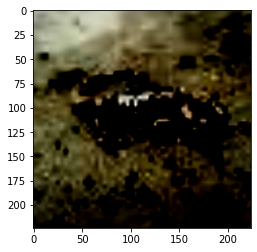

In [ ]:
image, label = trainData[0]
plt.imshow(image.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

<b>Number of images belonging to each class

In [ ]:
classCount = {}
for i,j in trainData: 
    labels = classes[j]
    if labels not in classCount:
        classCount[labels] = 0
    classCount[labels] += 1 
classCount 

{'n01629819': 500,
 'n01698640': 500,
 'n01768244': 500,
 'n01944390': 500,
 'n01945685': 500,
 'n01984695': 500,
 'n02085620': 500,
 'n02123394': 500,
 'n02129165': 500,
 'n02268443': 500,
 'n02281406': 500,
 'n02395406': 500,
 'n02481823': 500,
 'n02504458': 500,
 'n02730930': 500,
 'n02802426': 500,
 'n02808440': 500,
 'n02823428': 500,
 'n03085013': 500,
 'n03100240': 500,
 'n03179701': 500,
 'n03250847': 500,
 'n03355925': 500,
 'n03388043': 500,
 'n03544143': 500,
 'n03584254': 500,
 'n03649909': 500,
 'n03837869': 500,
 'n03891332': 500,
 'n03902125': 500,
 'n03930313': 500,
 'n03983396': 500,
 'n04099969': 500,
 'n04118538': 500,
 'n04179913': 500,
 'n04251144': 500,
 'n04265275': 500,
 'n04366367': 500,
 'n04399382': 500,
 'n04456115': 500,
 'n04487081': 500,
 'n04540053': 500,
 'n04562935': 500,
 'n04596742': 500,
 'n07583066': 500,
 'n07749582': 500,
 'n07768694': 500,
 'n07871810': 500,
 'n07873807': 500,
 'n12267677': 500}

<b>Creating DataLoaders to load the data in batches

In [ ]:
batch_size = 50
trainLoader = DataLoader(trainData, batch_size=batch_size, shuffle=True)
testLoader = DataLoader(testData, batch_size=batch_size, shuffle=True)

<b>Visualizing the Batch Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images Shape: torch.Size([100, 3, 224, 224])


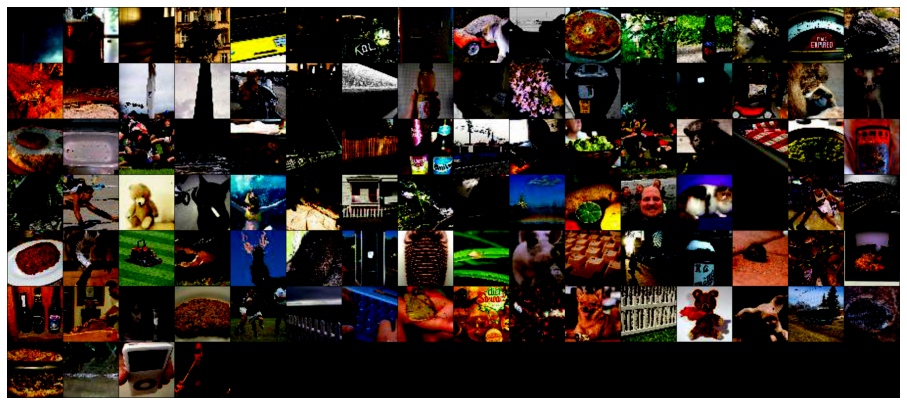

In [ ]:
for images, labels in trainLoader:
    print('Images Shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

<b>Train and Test data

In [ ]:
train_labels =trainData.classes
test_labels= testData.classes
train_images = trainData.imgs
test_images= testData.imgs

<b>Using Pretrained ResNet18 model

In [ ]:
model = models.resnet18(pretrained=True)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [ ]:
model.train()

n_epochs = 4

for epoch in range(n_epochs):
  n_correct =0.0
  r_loss=0.0

  for i, (images, labels) in enumerate(trainLoader):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(images)
        output_label = torch.argmax(output,dim=1)

        n_correct+= (labels==output_label).sum().item()

        optimizer.zero_grad()

        loss = loss_function(output, labels)
        r_loss += loss.item()*images.size(0)

        # Backward and optimize
        loss.backward()
        optimizer.step()

  print(f'Epoch:{epoch} Loss :{r_loss/len(trainData)}  Accuracy :{n_correct/len(trainData)*100}%')
print("Training Completed")

Epoch:0 Loss :3.2062629065513613  Accuracy :29.188%
Epoch:1 Loss :1.3966539959907531  Accuracy :61.832%
Epoch:2 Loss :1.1242835075855255  Accuracy :68.552%
Epoch:3 Loss :1.0095060589313507  Accuracy :71.72800000000001%
Epoch:4 Loss :0.9353173577785492  Accuracy :73.56%
Epoch:5 Loss :0.8869716322422028  Accuracy :74.836%
Training Completed


<b>Finetune resnet18 model

In [ ]:
tuned_model = models.resnet18(pretrained=True).to(device)
    
for param in tuned_model.parameters():
    param.requires_grad = False  

num_classes = len(classes)
tuned_model.fc = nn.Linear(512, num_classes)
tuned_model.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 50)).to(device)

In [ ]:
tuned_model = tuned_model.to(device)

In [ ]:
summary(tuned_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

<b>Cross-Entropy as the final classification loss function

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(tuned_model.fc.parameters())

In [ ]:
 torch.cuda.empty_cache()

In [ ]:
tuned_model.train()
confusion_matrix = torch.zeros(len(classes), len(classes))    
correct_predction = {label: 0 for label in classes}
total_predction = {label: 0 for label in classes}

#Number of epochs used =6
n_epochs = 10

for epoch in range(n_epochs):
  n_correct =0.0
  r_loss=0.0

  for i, (images, labels) in enumerate(trainLoader):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        output = tuned_model(images)
        output_label = torch.argmax(output,dim=1)

        n_correct+= (labels==output_label).sum().item()

        #Confusion matrix
        for t, p in zip(labels.view(-1), output_label.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        optimizer.zero_grad()

        loss = loss_function(output, labels)
        r_loss += loss.item()*images.size(0)

        # Backward and optimize
        loss.backward()
        optimizer.step()
  
  print(f'Epoch:{epoch} Loss :{r_loss/len(trainData)} f1 Score :{f1_score} Accuracy :{n_correct/len(trainData)*100}%')
print("Completed")

Epoch:0 Loss :1.8650309127569198 f1 Score :<function f1_score at 0x7fb716d94ef0> Accuracy :52.928%
Epoch:1 Loss :1.1486958615779876 f1 Score :<function f1_score at 0x7fb716d94ef0> Accuracy :67.364%
Epoch:2 Loss :1.0280085101127625 f1 Score :<function f1_score at 0x7fb716d94ef0> Accuracy :70.748%
Epoch:3 Loss :0.9683730068206787 f1 Score :<function f1_score at 0x7fb716d94ef0> Accuracy :72.21600000000001%
Epoch:4 Loss :0.9199486204385757 f1 Score :<function f1_score at 0x7fb716d94ef0> Accuracy :73.456%
Epoch:5 Loss :0.8928772776126862 f1 Score :<function f1_score at 0x7fb716d94ef0> Accuracy :74.024%
Epoch:6 Loss :0.8644607219696044 f1 Score :<function f1_score at 0x7fb716d94ef0> Accuracy :74.612%
Epoch:7 Loss :0.8428471851348877 f1 Score :<function f1_score at 0x7fb716d94ef0> Accuracy :75.28%
Epoch:8 Loss :0.8255913119912147 f1 Score :<function f1_score at 0x7fb716d94ef0> Accuracy :75.872%
Epoch:9 Loss :0.80792843657732 f1 Score :<function f1_score at 0x7fb716d94ef0> Accuracy :76.2040000

In [ ]:
print(confusion_matrix)

tensor([[4.2220e+03, 1.3700e+02, 1.0000e+00,  ..., 3.2000e+01, 1.4000e+01,
         2.3000e+01],
        [1.1900e+02, 3.5510e+03, 9.6000e+01,  ..., 1.1000e+01, 6.0000e+00,
         4.2000e+01],
        [9.0000e+00, 9.5000e+01, 4.1780e+03,  ..., 5.9000e+01, 1.9000e+01,
         2.2000e+01],
        ...,
        [1.0000e+01, 3.0000e+00, 7.6000e+01,  ..., 3.4950e+03, 3.7500e+02,
         1.9000e+01],
        [3.0000e+00, 3.0000e+00, 2.2000e+01,  ..., 3.0500e+02, 4.1040e+03,
         7.0000e+00],
        [5.6000e+01, 6.0000e+01, 3.9000e+01,  ..., 5.3000e+01, 1.0000e+01,
         3.0990e+03]])


In [ ]:
# recall score
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix.numpy(), axis = 1) # axis 1 means column values
print("Recall Score: ", recall)

Recall Score:  [0.8444 0.7102 0.8356 0.596  0.5676 0.7042 0.7088 0.7724 0.811  0.7472
 0.8964 0.5932 0.7698 0.8116 0.7314 0.6336 0.6608 0.5734 0.7224 0.8704
 0.7094 0.554  0.7318 0.5992 0.7444 0.7278 0.6804 0.807  0.603  0.708
 0.7016 0.48   0.6926 0.8014 0.5518 0.795  0.599  0.6938 0.6916 0.674
 0.9076 0.5994 0.8212 0.6294 0.7506 0.8612 0.82   0.699  0.8208 0.6198]


In [ ]:
# precision score
precision = np.diag(confusion_matrix.numpy()) / np.sum(confusion_matrix.numpy(), axis = 0) # axis 0 means row values
print("Precision Score: ",precision)

Precision Score:  [0.8171086  0.6602826  0.77356046 0.62935585 0.60641026 0.67568606
 0.71610427 0.7630903  0.7802578  0.7446681  0.8615917  0.628523
 0.721868   0.7706039  0.7084463  0.6262107  0.66653216 0.60870486
 0.7360913  0.8664145  0.63794965 0.57588357 0.7293203  0.62546974
 0.76710635 0.7101874  0.6656232  0.8094283  0.6542969  0.7008513
 0.71885246 0.5328597  0.70789045 0.78430223 0.5993917  0.7815572
 0.62670016 0.6758231  0.7012776  0.6813587  0.8713518  0.6301514
 0.81339145 0.658506   0.75573903 0.82680494 0.8        0.695384
 0.7918194  0.64602876]


In [ ]:
# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print("F1 Score for the classes: ", F1)

F1 Score for the classes:  [0.8305301  0.6843322  0.80338436 0.6122239  0.5863636  0.68964845
 0.7124334  0.76771694 0.79533195 0.7459319  0.8786512  0.61035085
 0.7450639  0.79057086 0.7197403  0.62988365 0.6636537  0.59052527
 0.72918135 0.8684027  0.6717803  0.56472987 0.73055804 0.61205316
 0.7555827  0.71888584 0.6729305  0.80821234 0.627602   0.7044075
 0.71012145 0.5050505  0.70016176 0.79275894 0.57461214 0.78822136
 0.6125371  0.6846936  0.69640523 0.6776594  0.8891066  0.61439115
 0.8172771  0.6436241  0.7531607  0.843652   0.80987656 0.6971873
 0.8060493  0.6326426 ]
